In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt

In [94]:
data = pd.read_csv('./data/calculate_stride_samea_walk.csv', header=None)
data.head(2)

,0,1,2,3,4,5,6,7,8
0,115.434860,31.173910,-148.859360,0.963800,0.632448,0.579744,0.009304,-0.132626,-0.563334
1,117.120712,29.339781,-146.815338,0.987224,0.758840,0.586088,0.009125,-0.133039,-0.560488


In [95]:
data.columns = ['gx', 'gy', 'gz', 'ax', 'ay', 'az', 'mx', 'my', 'mz']
data.head()

,gx,gy,gz,ax,ay,az,mx,my,mz
0,115.434860,31.173910,-148.859360,0.963800,0.632448,0.579744,0.009304,-0.132626,-0.563334
1,117.120712,29.339781,-146.815338,0.987224,0.758840,0.586088,0.009125,-0.133039,-0.560488
2,119.498901,27.083427,-143.722275,0.990640,0.695400,0.596336,0.008985,-0.135202,-0.557762
3,121.595383,25.735933,-140.915375,0.968680,0.677344,0.614880,0.008806,-0.136067,-0.561600
4,122.915810,25.085323,-138.590164,0.953064,0.627568,0.624640,0.009753,-0.136982,-0.563838


In [96]:
data = data.reset_index()
data.head(2)

,index,gx,gy,gz,ax,ay,az,mx,my,mz
0,0,115.434860,31.173910,-148.859360,0.963800,0.632448,0.579744,0.009304,-0.132626,-0.563334
1,1,117.120712,29.339781,-146.815338,0.987224,0.758840,0.586088,0.009125,-0.133039,-0.560488


In [97]:
# 采样频率1000Hz
data['time'] = data['index'].map(lambda x: round((x+1)/1000, 3))
data.head(2)

,index,gx,gy,gz,ax,ay,az,mx,my,mz,time
0,0,115.434860,31.173910,-148.859360,0.963800,0.632448,0.579744,0.009304,-0.132626,-0.563334,0.001
1,1,117.120712,29.339781,-146.815338,0.987224,0.758840,0.586088,0.009125,-0.133039,-0.560488,0.002


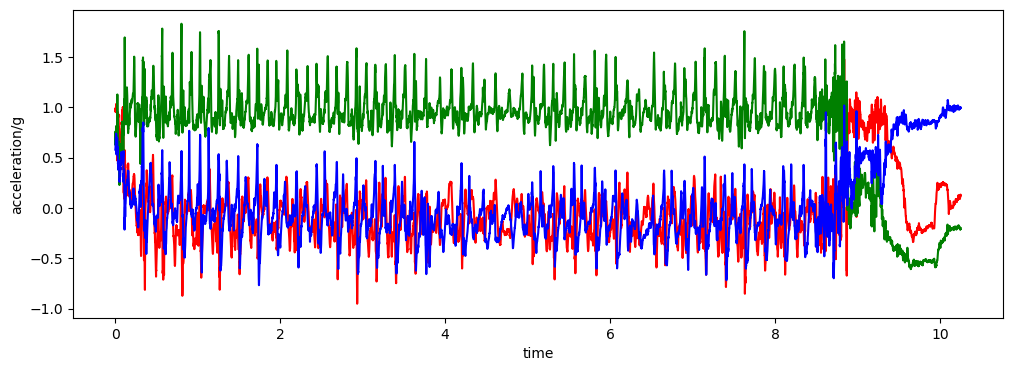

In [98]:
fig = plt.figure(figsize=(12, 4))
plt.plot(data['time'], data['ax'], 'r')
plt.plot(data['time'], data['ay'], 'g')
plt.plot(data['time'], data['az'], 'b')
plt.ylabel('acceleration/g')
plt.xlabel('time')
plt.show()

## 低通滤波

In [99]:
def low_pass_filter(data, cutoff_frequency, sampling_rate, order=4):
    """
    Apply a low-pass Butterworth filter to the data.

    Parameters:
        data (array-like): The input signal to be filtered.
        cutoff_frequency (float): The cutoff frequency of the filter (Hz).
        sampling_rate (float): The sampling rate of the input signal (Hz).
        order (int, optional): The order of the filter. Default is 4.

    Returns:
        filtered_data (array-like): The filtered signal.
    """
    # Normalize the cutoff frequency by the Nyquist frequency (half the sampling rate)
    nyquist_frequency = 0.5 * sampling_rate
    normalized_cutoff = cutoff_frequency / nyquist_frequency
    
    # Design the low-pass filter using the butter function
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)
    
    # Apply the filter to the data using filtfilt (zero-phase filtering)
    filtered_data = filtfilt(b, a, data)
    
    return filtered_data

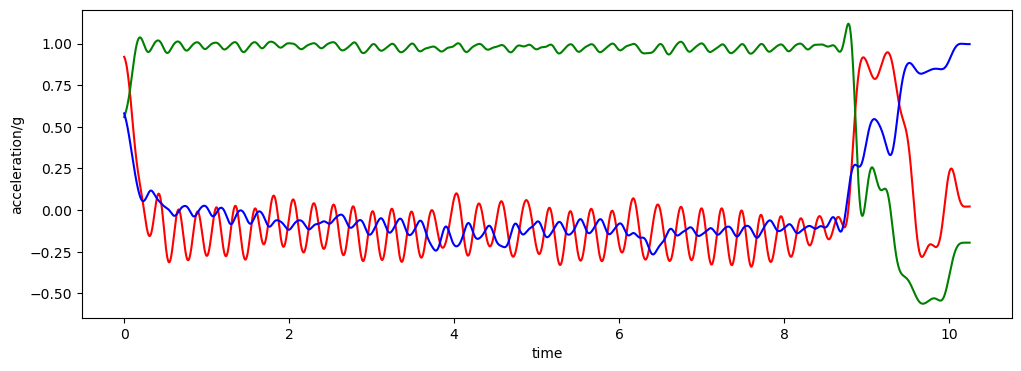

In [100]:
# 对三轴加速度进行低通滤波
cutoff_frequency = 5  # 人体步伐最大频率 
sampling_rate = 1000  # 采样频率Hz
data['ax_filter'] = low_pass_filter(data['ax'], cutoff_frequency, sampling_rate, order=4)
data['ay_filter'] = low_pass_filter(data['ay'], cutoff_frequency, sampling_rate, order=4)
data['az_filter'] = low_pass_filter(data['az'], cutoff_frequency, sampling_rate, order=4)

fig = plt.figure(figsize=(12, 4))
plt.plot(data['time'], data['ax_filter'], 'r')
plt.plot(data['time'], data['ay_filter'], 'g')
plt.plot(data['time'], data['az_filter'], 'b')
plt.ylabel('acceleration/g')
plt.xlabel('time')
plt.show()

## 剔除首尾异常值点

In [101]:
def find_discontinuous_ranges(data):
    """
    Find the maximum and minimum values in the discontinuous ranges of a list.
    
    Parameters:
        data (list): A list of numeric values that may contain discontinuous ranges.
        
    Returns:
        ranges (list of tuples): A list of tuples where each tuple contains the 
                                 (min_value, max_value) of a discontinuous range.
    """
    if not data:
        return []
    
    ranges = []
    current_min = current_max = data[0]
    
    for i in range(1, len(data)):
        # Check if there is a discontinuity
        if data[i] - data[i - 1] > 1:
            # Store the current range
            ranges.append((current_min, current_max))
            # Start a new range
            current_min = data[i]
        
        # Update the current range max
        current_max = data[i]
    
    # Append the last range
    ranges.append((current_min, current_max))
    
    return ranges

# Example usage
# data = [1, 2, 3, 10, 11, 12, 20, 21, 30, 31, 32]
# discontinuous_ranges = find_discontinuous_ranges(data)
# print(discontinuous_ranges)  # Output: [(1, 3), (10, 12), (20, 21), (30, 32)]


In [102]:
from scipy import stats

def remove_outliers(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    return data[z_scores > threshold].index

ax_error_index = remove_outliers(data['ax_filter'], threshold=1.2)
ay_error_index = remove_outliers(data['ay_filter'], threshold=1.2)
az_error_index = remove_outliers(data['az_filter'], threshold=1.2)

ax_error_index = find_discontinuous_ranges(list(ax_error_index))
ay_error_index = find_discontinuous_ranges(list(ay_error_index))
az_error_index = find_discontinuous_ranges(list(az_error_index))

print("x error index: ", ax_error_index)
print("y error index: ", ay_error_index)
print("z error index: ", az_error_index)


x error index:  [(0, 154), (8821, 9532)]
y error index:  [(8888, 10249)]
z error index:  [(0, 80), (8987, 9242), (9325, 10249)]


In [82]:
x_range = [200, 8700]
y_range = [200, 8700]
z_range = [200, 8700]

## 寻找波峰波谷

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


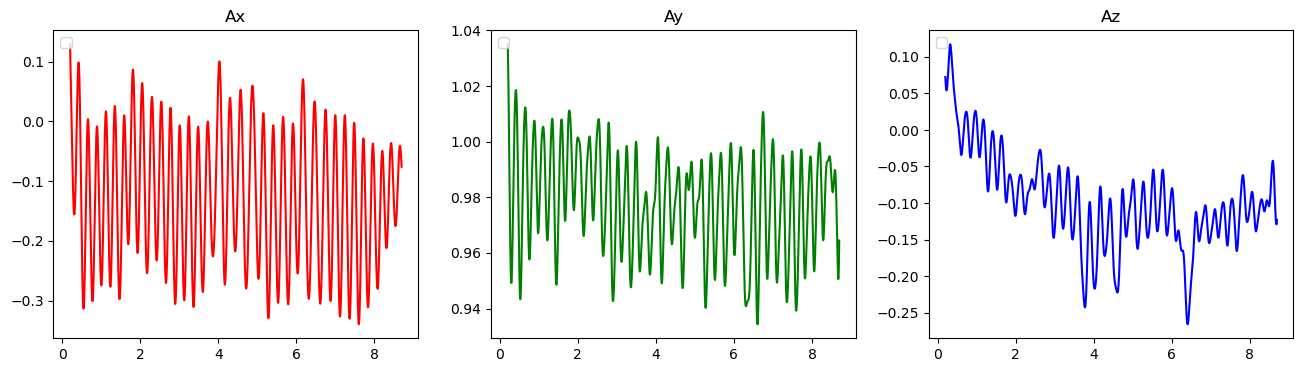

In [111]:
# 避免混乱，使用新数据进行后续计算
data_ax_filter = data['ax_filter'][x_range[0]: x_range[1]].reset_index(drop=True)
data_ax_time = data['time'][x_range[0]: x_range[1]].reset_index(drop=True)
data_ay_filter = data['ay_filter'][y_range[0]: y_range[1]].reset_index(drop=True)
data_ay_time = data['time'][y_range[0]: y_range[1]].reset_index(drop=True)
data_az_filter = data['az_filter'][z_range[0]: z_range[1]].reset_index(drop=True)
data_az_time = data['time'][z_range[0]: z_range[1]].reset_index(drop=True)

# Step 3: 找到波峰
ax_peaks, _ = find_peaks(data_ax_filter, prominence=0.1, distance=50)
ay_peaks, _ = find_peaks(data_ay_filter, prominence=0.01, distance=50)
az_peaks, _ = find_peaks(data_az_filter, prominence=0.01, distance=50)

# Step 4: 找到波谷 (通过对信号取负来寻找波谷)
ax_valleys, _ = find_peaks(-data_ax_filter, prominence=0.1, distance=50)
ay_valleys, _ = find_peaks(-data_ay_filter, prominence=0.01, distance=50)
az_valleys, _ = find_peaks(-data_az_filter, prominence=0.01, distance=50)

# ax_peaks = [x for x in list(ax_peaks) if x > x_range[0] and x < x_range[1]]
# ax_valleys = [x for x in list(ax_valleys) if x > x_range[0] and x < x_range[1]]

fig = plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(data_ax_time, data_ax_filter, 'r')
# plt.plot(data_ax_time[ax_peaks], data_ax_filter[ax_peaks], '^', label='Peaks', markersize=8)  # 波峰
# plt.plot(data_ax_time[ax_valleys], data_ax_filter[ax_valleys], 'v', label='Valleys', markersize=8)  # 波谷
plt.title('Ax')
plt.legend(loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(data_ay_time, data_ay_filter, 'g')
# plt.plot(data_ay_time[ay_peaks], data_ay_filter[ay_peaks], '^', label='Peaks', markersize=8)  # 波峰
# plt.plot(data_ay_time[ay_valleys], data_ay_filter[ay_valleys], 'v', label='Valleys', markersize=8)  # 波谷
plt.title('Ay')
plt.legend(loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(data_az_time, data_az_filter, 'b')
# plt.plot(data_az_time[az_peaks], data_az_filter[az_peaks], '^', label='Peaks', markersize=8)  # 波峰
# plt.plot(data_az_time[az_valleys], data_az_filter[az_valleys], 'v', label='Valleys', markersize=8)  # 波谷
plt.title('Az')
plt.legend(loc='upper left')

plt.show()

In [115]:
az_peaks.shape

(33,)

In [66]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import uniform_filter1d

# Step 1: 生成示例波形数据
t = np.arange(0, 10, 0.01)  # 采样时间
y = np.sin(2 * np.pi * 0.5 * t) + 0.05 * np.random.randn(len(t))  # 带噪声的波形数据

# Step 2: 平滑数据 (可选)
y_smooth = uniform_filter1d(y, size=10)  # 使用移动平均平滑

# Step 3: 找到波峰
peaks, _ = find_peaks(y_smooth, prominence=0.1, distance=50)

# Step 4: 找到波谷 (通过对信号取负来寻找波谷)
valleys, _ = find_peaks(-y_smooth, prominence=0.1, distance=50)

# Step 5: 标记上升和下降过程
# 上升过程：波谷到波峰，下降过程：波峰到波谷
for i in range(min(len(peaks), len(valleys)) - 1):
    rise_start = valleys[i]
    rise_end = peaks[i]
    fall_start = peaks[i]
    fall_end = valleys[i + 1]

    # 上升和下降阶段数据提取
    rise_phase = y_smooth[rise_start:rise_end]
    fall_phase = y_smooth[fall_start:fall_end]

    print(f'上升过程 {i + 1}: 从时间 {t[rise_start]} 到 {t[rise_end]}')
    print(f'下降过程 {i + 1}: 从时间 {t[fall_start]} 到 {t[fall_end]}')

# Step 6: 可视化波形、波峰和波谷



上升过程 1: 从时间 1.48 到 0.5
下降过程 1: 从时间 0.5 到 3.47
上升过程 2: 从时间 3.47 到 2.47
下降过程 2: 从时间 2.47 到 5.48
上升过程 3: 从时间 5.48 到 4.48
下降过程 3: 从时间 4.48 到 7.49
上升过程 4: 从时间 7.49 到 6.5
下降过程 4: 从时间 6.5 到 9.51


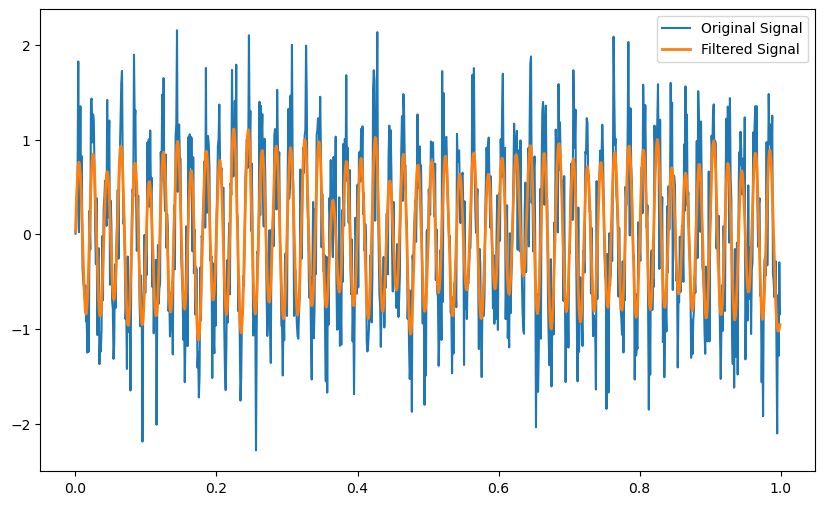

In [67]:
import numpy as np




# Example usage
if __name__ == "__main__":
    # Create a sample signal (a noisy sine wave)
    sampling_rate = 1000  # Hz
    t = np.linspace(0, 1.0, int(1.0 * sampling_rate), endpoint=False)
    freq = 50.0  # Frequency of the sine wave (Hz)
    signal = np.sin(2 * np.pi * freq * t) + 0.5 * np.random.randn(len(t))
    
    # Apply the low-pass filter (cutoff frequency = 60 Hz)
    cutoff_frequency = 60.0  # Hz
    filtered_signal = low_pass_filter(signal, cutoff_frequency, sampling_rate)
    
    # Plot the original and filtered signals
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(t, signal, label='Original Signal')
    plt.plot(t, filtered_signal, label='Filtered Signal', linewidth=2)
    plt.legend()
    plt.show()
